### Libraries Import

In [ ]:
import torch
from dataset import PromptDataset
from datasets import load_dataset
from model import ModelWrapper
from feature_extraction import get_prediction_trajectory
from anomaly_detection import AnomalyDetector
from utils import *
import numpy as np

import matplotlib.pyplot as plt
from tqdm import tqdm


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Adversarial vs Normal Trajectories for GPT-2 Large using a Pre-trained Tuned Lens:

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:818: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tuned_lens/nn/lenses.py:277: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add

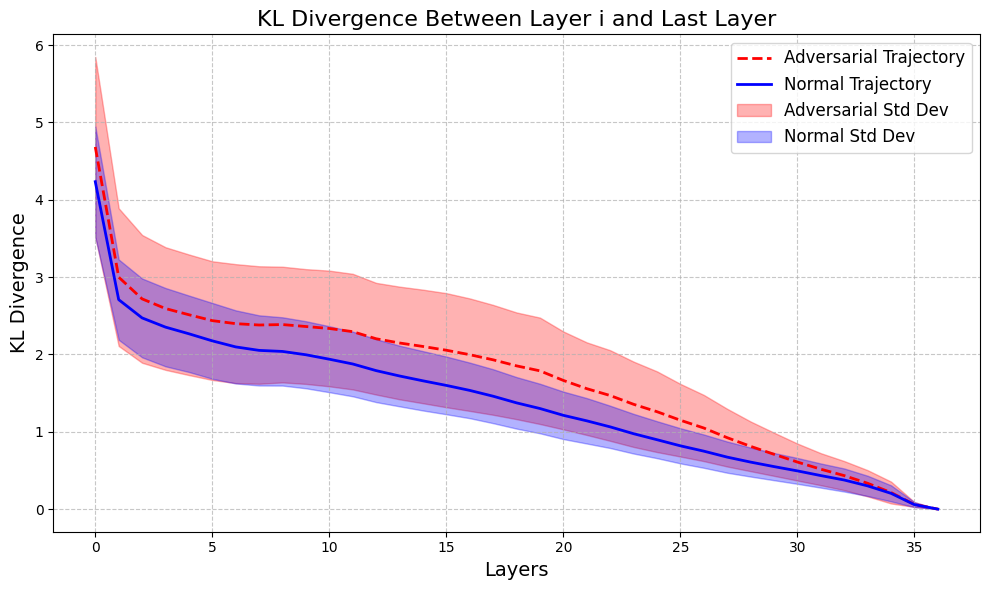

In [ ]:
adversarial = load_dataset('deepset/prompt-injections', split='train')
normal = load_dataset("agentlans/high-quality-english-sentences", split='train')

model_wrapper = ModelWrapper()
model = model_wrapper.get_model()
tokenizer = model_wrapper.get_tokenizer()
lens = model_wrapper.get_lens()


# Extract prediction trajectories for training (this can be batched or parallelized as needed)
normal_trajectories = []
for prompt in normal['text'][:200]:
    traj = get_prediction_trajectory(prompt,  model, tokenizer, lens)
    if traj is not None and len(traj) > 0:
        normal_trajectories.append(traj)

adversarial_trajectories = []
for batch in adversarial:
    if batch['label'] == 0:
        continue
    prompt = batch['text']
    traj = get_prediction_trajectory(prompt,  model, tokenizer, lens)
    if traj is not None and len(traj) > 0:
        adversarial_trajectories.append(traj)

# Assuming `normal_trajectories` and `adversarial_trajectories` are already calculated
mean_normal = np.mean(normal_trajectories, axis=0)
mean_adversial = np.mean(adversarial_trajectories, axis=0)
std_normal = np.std(normal_trajectories, axis=0)  # Calculate standard deviation for normal
std_adversial = np.std(adversarial_trajectories, axis=0)  # Calculate standard deviation for adversarial

# Plot the trajectories with hashed standard deviation
plt.figure(figsize=(10, 6))  # Set a larger figure size
plt.plot(mean_adversial, label="Adversarial Trajectory", linestyle='--', color='red', linewidth=2)
plt.plot(mean_normal, label="Normal Trajectory", linestyle='-', color='blue', linewidth=2)

# Add shaded areas for standard deviations
plt.fill_between(
    range(len(mean_adversial)),
    mean_adversial - std_adversial,
    mean_adversial + std_adversial,
    color='red',
    alpha=0.3,
    label="Adversarial Std Dev"
)
plt.fill_between(
    range(len(mean_normal)),
    mean_normal - std_normal,
    mean_normal + std_normal,
    color='blue',
    alpha=0.3,
    label="Normal Std Dev"
)

# Add labels, title, and legend
plt.xlabel("Layers", fontsize=14)  # Label for x-axis
plt.ylabel("KL Divergence", fontsize=14)  # Label for y-axis
plt.title("KL Divergence Between Layer i and Last Layer", fontsize=16)  # Add a descriptive title
plt.legend(fontsize=12)  # Add a legend with appropriate font size
plt.grid(True, linestyle='--', alpha=0.7)  # Add grid lines for better readability

# Show the plot
plt.tight_layout()  # Adjust layout to prevent overlap
# Save the plot as an image file
plt.savefig("kl_divergence_plot.png", dpi=300, bbox_inches='tight')  # Save as a PNG file with high resolution

# Optionally show the plot
plt.show()

### Load Dataset:

In [ ]:
# Load and split dataset
dataset = PromptDataset.from_huggingface(adversarial_dataset='deepset/prompt-injections',
                          normal_dataset="agentlans/high-quality-english-sentences")
train_data, test_data = dataset.split()

### Anamoly Detection for GPT2-Large:

**Using Tuned Lens**

In [ ]:
# Extract prediction trajectories for training 
train_trajectories = []
for prompt in tqdm(train_data.normal_prompts, desc="Processing training prompts"):
    traj = get_prediction_trajectory(prompt,  model, tokenizer, lens)
    if traj is not None:
        train_trajectories.append(traj)

# Initialize anomaly detector
detector = AnomalyDetector(lens='tuned_lens')

# Train anomaly detectors
detector.train_detectors(train_trajectories)

# Evaluate on test data
print("Evaluating...")
results = detector.evaluate(test_data)
print("Results:", results)

config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.25G [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:818: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(


generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

params.pt:   0%|          | 0.00/236M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/198 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/tuned_lens/nn/lenses.py:277: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = th.load(ckpt_path, **th_load_kwargs)
Processing tr

Evaluating...
Results: {'iforest_auroc': 0.2354, 'lof_auroc': 0.24250000000000002, 'srm_auroc': 0.3387}


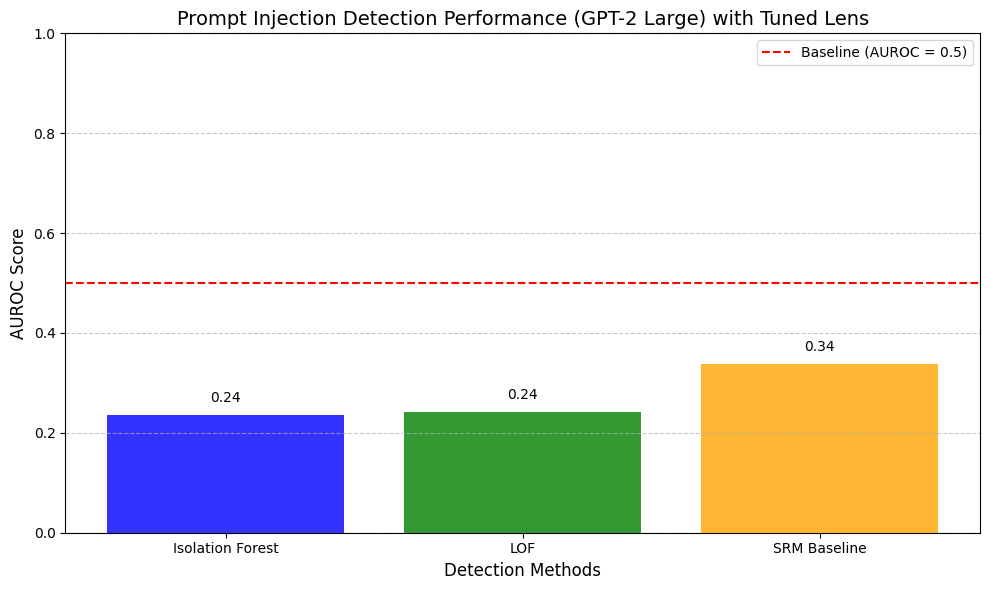

In [ ]:
plot_auroc_score(results, model_name='GPT-2 Large', lens_type='Tuned Lens')

**Using Logit Lens**

In [ ]:
model_wrapper = ModelWrapper(len_type='logit_lens')
model = model_wrapper.get_model()
tokenizer = model_wrapper.get_tokenizer()
lens = model_wrapper.get_lens()

# Extract prediction trajectories for training (this can be batched or parallelized as needed)
train_trajectories = []
for prompt in tqdm(train_data.normal_prompts, desc="Processing training prompts"):
    traj = get_prediction_trajectory(prompt,  model, tokenizer, lens)
    if traj is not None:
        train_trajectories.append(traj)

# Initialize anomaly detector
detector = AnomalyDetector(lens='logit_lens')

# Train anomaly detectors
detector.train_detectors(train_trajectories)

# Evaluate on test data
print("Evaluating...")
results = detector.evaluate(test_data)
print("Results:", results)


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:818: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Processing training prompts: 100%|██████████| 400/400 [25:45<00:00,  3.86s/it]


Evaluating...
Results: {'iforest_auroc': 0.22590000000000005, 'lof_auroc': 0.22070000000000004, 'srm_auroc': 0.244}


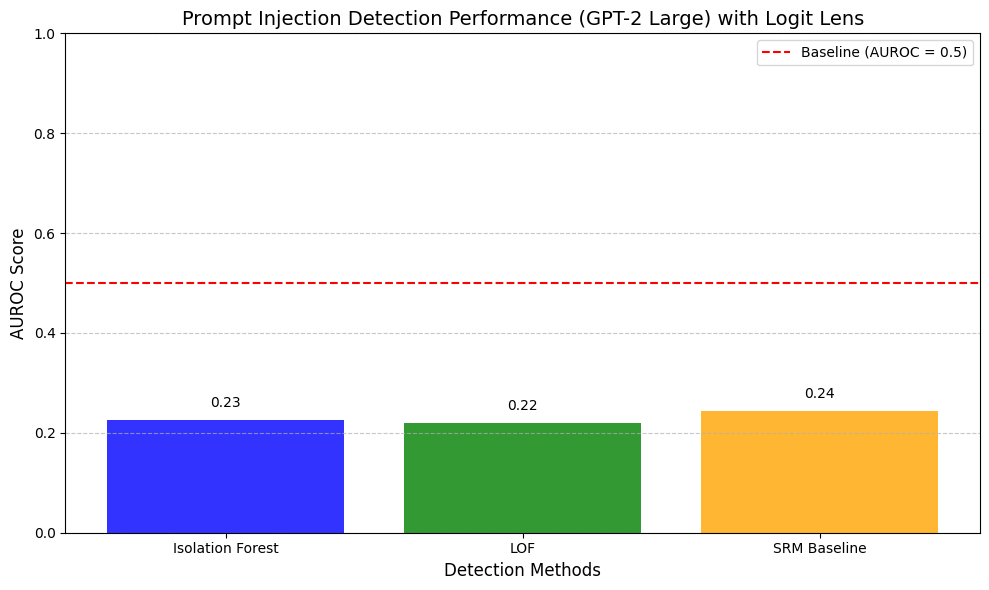

In [ ]:
plot_auroc_score(results, model_name='GPT-2 Large', lens_type='Logit Lens')

### Anomaly Detection for GPT-2:

**Using Tuned Lens**

In [ ]:
model_wrapper = ModelWrapper(model_name='gpt2')
model = model_wrapper.get_model()
tokenizer = model_wrapper.get_tokenizer()
lens = model_wrapper.get_lens()

# Extract prediction trajectories for training 
train_trajectories = []
for prompt in tqdm(train_data.normal_prompts, desc="Processing training prompts"):
    traj = get_prediction_trajectory(prompt,  model, tokenizer, lens)
    if traj is not None:
        train_trajectories.append(traj)

# Initialize anomaly detector
detector = AnomalyDetector(lens='tuned_lens')

# Train anomaly detectors
detector.train_detectors(train_trajectories)

# Evaluate on test data
print("Evaluating...")
results = detector.evaluate(test_data)
print("Results:", results)

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:818: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(


generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

params.pt:   0%|          | 0.00/28.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/tuned_lens/nn/lenses.py:277: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = th.load(ckpt_path, **th_load_kwargs)
Processing tr

Evaluating...
Results: {'iforest_auroc': 0.2107, 'lof_auroc': 0.2643, 'srm_auroc': 0.2891}


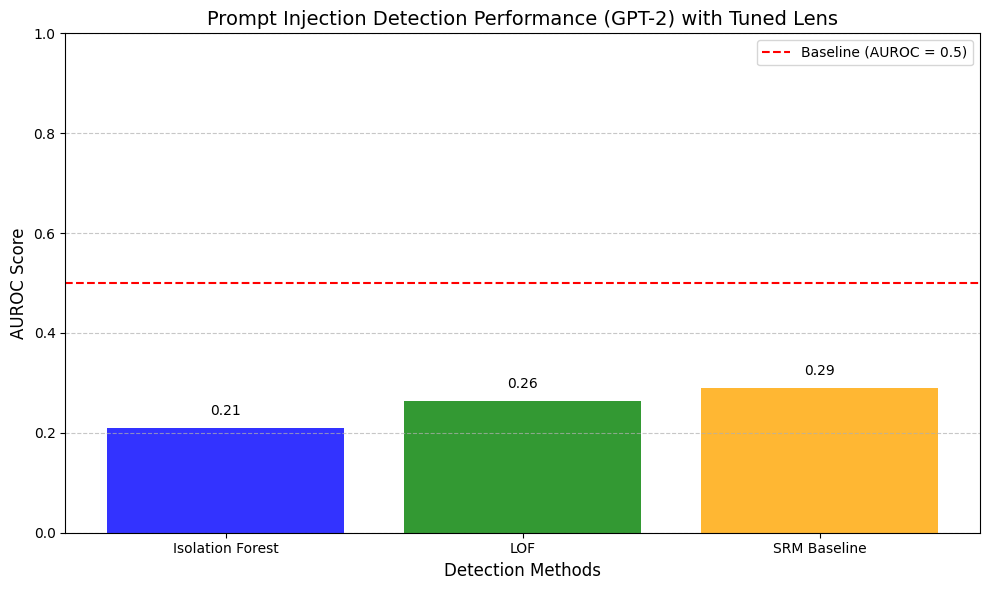

In [ ]:
plot_auroc_score(results, model_name='GPT-2', lens_type='Tuned Lens')

**Using Logit Lens**

In [ ]:
model_wrapper = ModelWrapper(model_name='gpt2', lens_type='logit_lens')
model = model_wrapper.get_model()
tokenizer = model_wrapper.get_tokenizer()
lens = model_wrapper.get_lens()

# Extract prediction trajectories for training 
train_trajectories = []
for prompt in tqdm(train_data.normal_prompts, desc="Processing training prompts"):
    traj = get_prediction_trajectory(prompt,  model, tokenizer, lens)
    if traj is not None:
        train_trajectories.append(traj)

# Initialize anomaly detector
detector = AnomalyDetector(lens='logit_lens')

# Train anomaly detectors
detector.train_detectors(train_trajectories)

# Evaluate on test data
print("Evaluating...")
results = detector.evaluate(test_data)
print("Results:", results)

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:818: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Processing training prompts: 100%|██████████| 400/400 [09:06<00:00,  1.37s/it]


Evaluating...
Results: {'iforest_auroc': 0.13710000000000003, 'lof_auroc': 0.1416, 'srm_auroc': 0.1669}


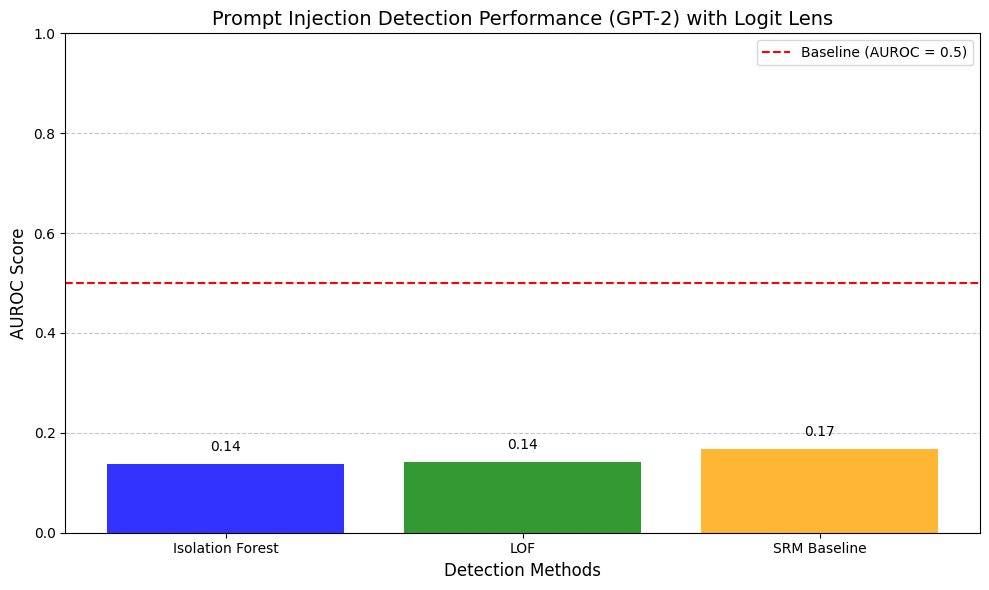

In [ ]:
plot_auroc_score(results, model_name='GPT-2', lens_type='Logit Lens')